In [1]:
%load_ext autoreload
%autoreload 2

## Apprentissage des aspects explicites

### Importation des bibliothèques

In [2]:
import os
os.chdir("..")

In [3]:
import seaborn as sns
from collections import Counter
from time import time
from Preprocessors.ReviewPreprocessor import ReviewPreprocessor
from Aspects.ExplicitAspectExtractor import ExplicitAspectExtractor
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

### Fonction de pretraitement des datasets

La fonction prend un dictionnaire de jeux de données. il a comme clé un nom pour identifier le dataset et comme valeur le chemin vers le dataset.

In [4]:
def clean_datasets(datasets):
    cleaned_datasets = []
    for dataset_name in datasets:
        print(f"cleaning dataset {dataset_name}")
        dataset = pd.read_csv(datasets[dataset_name])
        old = time()
        review_preprocessor = ReviewPreprocessor(dataset['review'], nlp)
        dataset['cleaned_data'] = review_preprocessor.remove_tags()
        dataset['cleaned_data'] = review_preprocessor.lowercase_transformation()
        dataset['cleaned_data'] = review_preprocessor.pararel_spelling_correction()
        dataset['cleaned_data'] = review_preprocessor.remove_objective_sentences()
        dataset = dataset[dataset['cleaned_data'] != ""]
        print(f"cleaning {dataset_name} took {time() - old}")
        cleaned_datasets.append((dataset_name, dataset))
    return cleaned_datasets

### Fonction d'extraction des aspects et de calcule de proportion de chaque aspect.

La fonction prend comme paramètre un dictionnaire des datasets prétraités. Il applique l'algorithme de l'extraction des aspects explicites avec leur nombre d'occurrence. Pour calculer la proportion de chaque aspect nous utilisons la relation suivante:

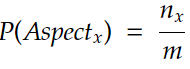

avec 

- **nx :** le nombre d'occurrence de l'aspect x.
- **m:** la somme d'occurrence de tous les aspects fréquents.

In [5]:
def extract_aspects_with_proportion(cleaned_datasets, aspects_threshold = 250):
    result = []
    for cleaned_dataset in cleaned_datasets:
        print(f"extracting aspects from {cleaned_dataset[0]}")
        old = time()
        explicit_aspect_extractor = ExplicitAspectExtractor(cleaned_dataset[1]['cleaned_data'], nlp)
        explicit_aspect_extractor.extract_aspects()
        frequent_aspects = explicit_aspect_extractor.get_frequent_aspects(aspects_threshold)
        sum_occurences = sum(Counter(dict(frequent_aspects)).values())
        aspects_proportion = []
        for i in frequent_aspects:
            aspects_proportion.append((i[0], i[1]/sum_occurences))
        result.append((cleaned_dataset[0], frequent_aspects, aspects_proportion))
        print(f"duration took for extracting explicit aspects and convert to proportion {time() - old}")
    return result

### Application de prétraitement

Les jeux de données utilisés dans cette notebook sont collectés à l'aide de module de scraping créé pour le projet.

- les datasets **tripadvisor**, **booking** et **agoda** contient des commentaires de 10 hôtels à Paris, en total chaque dataset contient respectivement 2141, 1022, 230 commentaires.
- les datasets **agoda_london** et **tripadivsor_london** contient des commentaires de 5 hôtels à Londres, en total chaque dataset contient respectivement 245 et 658.

In [6]:
old = time()
datasets = {'tripadvisor': 'data/3 datasets/reviews_TripAdvisor_2022_5_20_11_27_56_ 10pages_10hotels.csv',
                    'booking': 'data/3 datasets/reviews_Booking_2022_5_20_11_9_54_10links_10_pages.csv',
                    'agoda': 'data/3 datasets/reviews_Agoda_2022_5_20_10_58_5_10pages_10_links.csv',
                    'agoda_london':'data/3 datasets/reviews_Agoda_2022_5_21_11_32_11_London_5pages_5links.csv',
                    'tripadvisor_london': 'data/3 datasets/reviews_TripAdvisor_2022_5_21_11_51_26_london_5pages_5links.csv'}
cleaned_datasets = clean_datasets(datasets)
print(f"duration : {time() - old}")

cleaning dataset tripadvisor


2141it [01:06, 32.11it/s]


cleaning tripadvisor took 264.56770300865173
cleaning dataset booking


1022it [00:13, 73.02it/s]


cleaning booking took 41.86551642417908
cleaning dataset agoda


230it [00:03, 63.32it/s]


cleaning agoda took 17.70045804977417
cleaning dataset agoda_london


245it [00:03, 66.51it/s]


cleaning agoda_london took 23.623052835464478
cleaning dataset tripadvisor_london


658it [00:18, 36.40it/s]

cleaning tripadvisor_london took 68.12376713752747
duration : 418.884343624115


### Application d'extraction des aspects explicites.

In [7]:
all_aspects_prob_freq = extract_aspects_with_proportion(cleaned_datasets)

extracting aspects from tripadvisor
duration took for extracting explicit aspects and convert to proportion 33.340646266937256
extracting aspects from booking
duration took for extracting explicit aspects and convert to proportion 7.794357061386108
extracting aspects from agoda
duration took for extracting explicit aspects and convert to proportion 1.7650060653686523
extracting aspects from agoda_london
duration took for extracting explicit aspects and convert to proportion 2.249317169189453
extracting aspects from tripadvisor_london
duration took for extracting explicit aspects and convert to proportion 10.27892518043518


**Affichage des valeurs de proportion pour les 30 aspects explicites les plus fréquents.**

In [8]:
only_aspects = []
for all_aspect_prob_freq in all_aspects_prob_freq:
    print(all_aspect_prob_freq[0])
    print("--------------------------------------------------")
    print(all_aspect_prob_freq[2][0:30])
    print("===================================")
    only_aspects.append(set(dict(all_aspect_prob_freq[1]).keys()))

tripadvisor
--------------------------------------------------
[('hotel', 0.09781887849089971), ('room', 0.08919755360695601), ('staff', 0.04686463783066834), ('breakfast', 0.03931176774003389), ('location', 0.03297472551764793), ('day', 0.01646894112445656), ('restaurant', 0.016321568049517354), ('stay', 0.01606366516837374), ('night', 0.014958367106329674), ('area', 0.014184658462898828), ('service', 0.014074128656694423), ('drink', 0.012747770982241545), ('bed', 0.012158278682484711), ('bar', 0.011716159457667085), ('time', 0.011163510426645052), ('bathroom', 0.010979294082971042), ('snack', 0.010647704664357821), ('eiffel', 0.01061086139562302), ('tower', 0.00943187679610935), ('place', 0.009395033527374549), ('lot', 0.0085476383464741), ('metro', 0.008437108540269692), ('coffee', 0.008363422002800089), ('minute', 0.007773929703043254), ('floor', 0.007294967209490826), ('reception', 0.007221280672021222), ('shower', 0.007073907597082013), ('station', 0.006779161447203596), ('street

In [9]:
len(set.intersection(*only_aspects))

221

- Parmi 250 aspects extraits depuis chaque dataset, il y a 221 aspects communs entre les cinq datasets.
- les aspects plus fréquents ont des valeurs de proportion proches entre eux. par exemple
    - l'aspects room {tripadvisor : 0.0891, booking: 0.0938, agoda: 0.0938, agoda_london: 0.0951, tripadvisor_london:0.0947}
    - l'aspects hotel {tripadvisor : 0.0978, booking: 0.0926, agoda: 0.0926, agoda_london: 0.0920, tripadvisor_london:0.0908}

### Construction d'un dataframe aspect/dataset

le dataframe a comme colonnes les aspects, et comme lignes le nom de dataset et comme valeurs la proportion calculé multiplié par 100.

ce dataframe est construit afin de calculer la variance de proportion pour aspects.

In [10]:
pds = []
for all_aspect_prob_freq in all_aspects_prob_freq:
    test_ = pd.DataFrame(all_aspect_prob_freq[2], columns=['aspect', 'proportion']).transpose()
    test_.columns = test_.loc['aspect',:]
    test_ = test_.drop('aspect')
    pds.append(test_)

In [11]:
rounded_proportion = pd.concat([pds[0], pds[1], pds[2], pds[3], pds[4]]).dropna(axis=1)*100
rounded_proportion.index = list(datasets.keys())

In [12]:
rounded_proportion

aspect,hotel,room,staff,breakfast,location,day,restaurant,stay,night,area,...,hallway,light,rate,parking,carpet,reason,entrance,cleanliness,cup,pressure
tripadvisor,9.781888,8.919755,4.686464,3.931177,3.297473,1.646894,1.632157,1.606367,1.495837,1.418466,...,0.08474,0.08474,0.08474,0.08474,0.08474,0.081055,0.081055,0.077371,0.077371,0.073687
booking,9.262132,9.38875,4.858979,3.925169,3.545314,1.560571,1.595391,1.506758,1.490931,1.319996,...,0.088633,0.098129,0.085467,0.158273,0.126618,0.098129,0.085467,0.091798,0.082302,0.085467
agoda,9.262441,9.388231,4.887403,3.881082,3.647911,1.546297,1.583113,1.497208,1.481868,1.310057,...,0.085905,0.098178,0.085905,0.153402,0.128858,0.101246,0.085905,0.09511,0.082837,0.082837
agoda_london,9.201784,9.51481,4.934589,3.779937,3.679532,1.509022,1.547412,1.509022,1.541505,1.290494,...,0.085639,0.100405,0.085639,0.156513,0.135841,0.100405,0.082686,0.097451,0.094498,0.085639
tripadvisor_london,9.082493,9.472299,5.074794,3.630074,3.595966,1.420358,1.5373,1.600643,1.598207,1.266871,...,0.080398,0.126687,0.099888,0.143741,0.136432,0.116942,0.082834,0.08527,0.08527,0.102324


### Calcul de Variance et écart type

In [13]:
vars_ = rounded_proportion.var()
stds_ = rounded_proportion.std()

In [14]:
vars_ = vars_.sort_values(ascending=False)
stds_ = stds_.sort_values(ascending=False)

#### Graphique des variances

In [37]:
sns.set(rc={'figure.figsize':(18,8)})

**variance des 30 premier aspects explicites**

<AxesSubplot:>

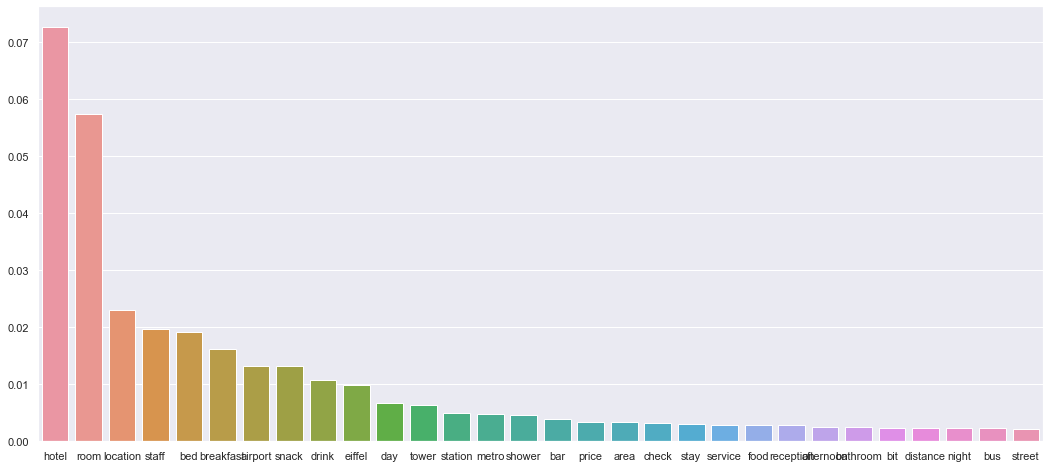

In [38]:
sns.barplot(x = list(vars_.index)[0:30], y= list(vars_)[0:30])

**variance des 30 dernier aspects explicites**

<AxesSubplot:>

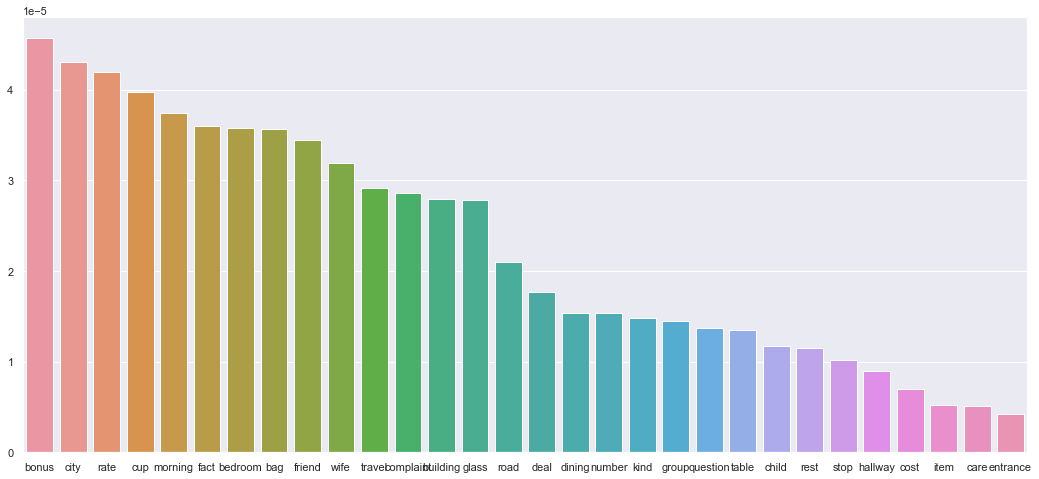

In [39]:
sns.barplot(x = list(vars_.index)[-30:], y= list(vars_)[-30:])

#### Graphique des écarts-types.

**écart type des 30 premier aspects explicites.**

<AxesSubplot:>

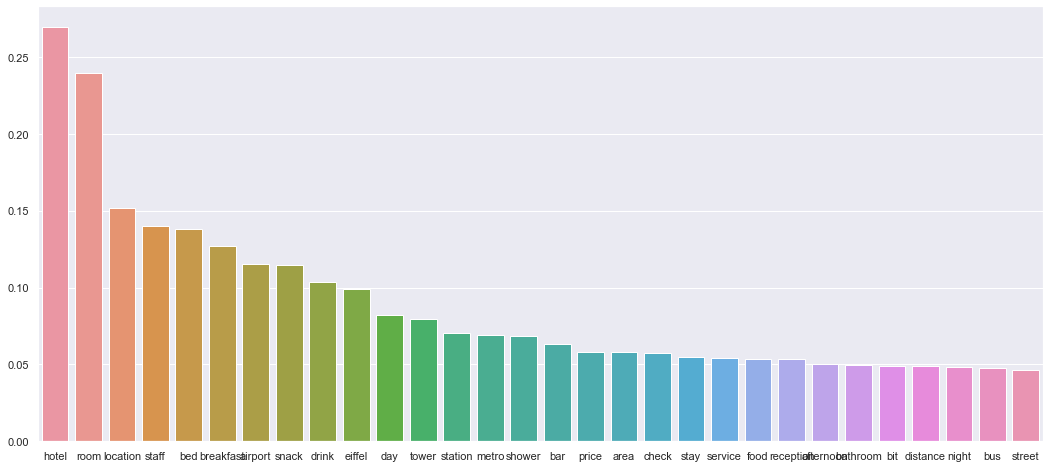

In [42]:
sns.barplot(x = list(stds_.index)[0:30], y= list(stds_)[0:30])

**écart type des 30 dernier aspects explicites.**

<AxesSubplot:>

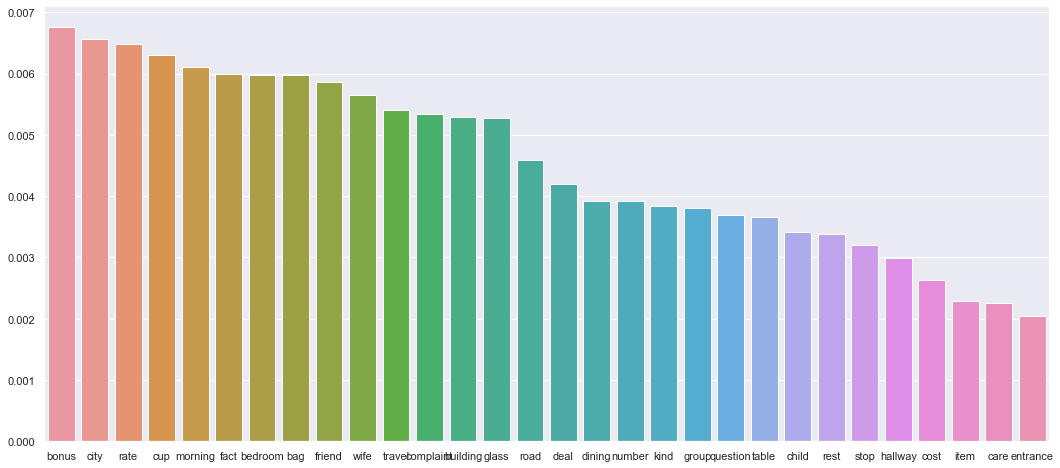

In [43]:
sns.barplot(x = list(stds_.index)[-30:], y= list(stds_)[-30:])

### Interprétations

- Les aspects les plus fréquents dans les quatre jeux de données ont une petite variance , par exemple pour l’aspect hotel il a comme variance la valeur 0,07.
- Si on compare la variance de l’aspect ‘hotel’ (0,07) avec la variance de l’aspect ‘lobby’ (0,0005), nous remarquons que la variance de ‘hotel’ est plus grande que ‘lobby’. Cette grande différence est due aux valeurs de proportions de ‘lobby’ qui sont proches de zéro.

In [18]:
rounded_proportion['lobby']

tripadvisor           0.464225
booking               0.433668
agoda                 0.423391
agoda_london          0.410478
tripadvisor_london    0.406861
Name: lobby, dtype: object

In [19]:
rounded_proportion['hotel']

tripadvisor           9.781888
booking               9.262132
agoda                 9.262441
agoda_london          9.201784
tripadvisor_london    9.082493
Name: hotel, dtype: object

In [20]:
vars_['hotel'], vars_['lobby']

(0.07259244659153166, 0.0005297912699953506)